# Digit recognizer

This project is made for those who want to start in computer vision. During my learning path I will include other versions of this project.

For version number 1, I will try to make a digit recognizer algorithm using convolutional neural networks.

So, the main steps I want to do are:

1. Load the data
2. Explore and preprocess the data into training, testing and validating sets
3. Define the Network architecture
4. Train and validate the data
5. Test and load the model
6. Visualize sample results

In version 1, we are going to do the digit recognizer using convolutional neural networks in PyTorch with no transfer learning and no data augmentation. These are reserved for other versions.

### Load the Data

In [26]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# How many samples per batch to load
batch_size = 20

# percentage of the training set to use as validation
valid_size = 0.2

transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

train_data = datasets.MNIST('data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('data', train=False, download=True, transform=transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

classes = list(range(10))

### Visualize the Data

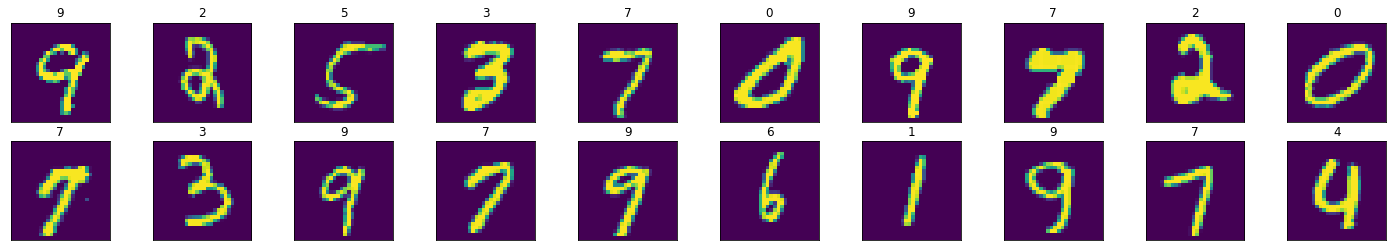

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(img.squeeze())
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in more detail

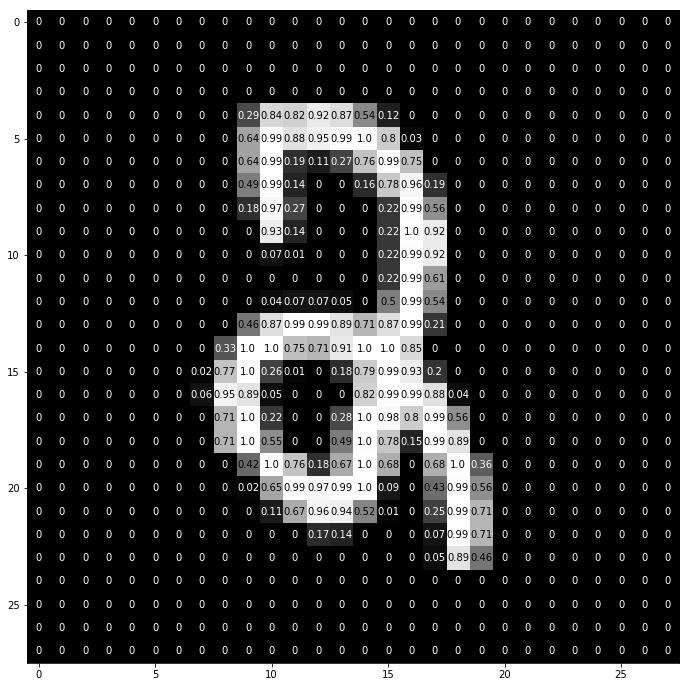

In [30]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## Define a Network Architecture

In [73]:
import torch.nn as nn
import torch.nn.functional as F


# For a start, we will define a 6 layer neural network, 3 convolutional layers with max-pooling layer
# and 3 fully-connected layers for classifying an image, which we will have 10 outputs
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # layer sees 28x28x1 image tensor
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        # layer sees 14x14x8 image tensor
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        # layer sees 7x7x16 image tensor
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        
        # max pooling layer used to reduce the spatial dimensionality of image by 2
        self.pool = nn.MaxPool2d(2, 2)
        
        # linear layer (32 * 3 * 3 -> 256)
        self.fc1 = nn.Linear(32 * 3 * 3, 256)
        # linear layer (256 -> 128)
        self.fc2 = nn.Linear(256, 128)
        # linear layer (128 -> 10)
        self.fc3 = nn.Linear(128, 10)
        
        # dropout module
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
        # Pass through convolutional layers, no dropouts used
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # flattening to the vector, passing it to fully connected layers and adding dropout
        # except the last layer for classification scores
        x = x.view(-1, 32 * 3 * 3)
        x = self.dropout(x)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc3(x))
        
        return x
    
model = Network()
print(model)

Network(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=288, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


### Define Loss Function and Optimizer

In [74]:
import torch.optim as optim

# We need to use Cross Entropy Loss for usual classification problems
criterion = nn.CrossEntropyLoss()

# Stochastic Gradient Descent used now for version 1 of Digit Recognizer
optimizer = optim.SGD(model.parameters(), lr=0.1)

### Training the Network

In [75]:
epochs = 30

valid_loss_min = np.Inf # track changes in validation loss

train_losses = list()
valid_losses = list()

for e in range(1, epochs + 1):
    train_loss = 0.0
    valid_loss = 0.0
    
    # We want to use the modules like dropout for training
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # We need to restart optimizer
        optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    
    # Now we want to evaluate the model
    model.eval()
    for data, target in valid_loader:
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining loss: {:.6f} \tValidation loss: {:.6f}'.format(
        e, train_loss, valid_loss))
    
    if valid_loss <= valid_loss_min:
        print('Valid loss decreased: {:.6f}. Saving model...'.format(valid_loss))
        torch.save(model.state_dict(), 'model_v1.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training loss: 0.518654 	Validation loss: 0.018662
Valid loss decreased: 0.018662. Saving model...
Epoch: 2 	Training loss: 0.095356 	Validation loss: 0.015180
Valid loss decreased: 0.015180. Saving model...
Epoch: 3 	Training loss: 0.075091 	Validation loss: 0.013974
Valid loss decreased: 0.013974. Saving model...
Epoch: 4 	Training loss: 0.058340 	Validation loss: 0.009688
Valid loss decreased: 0.009688. Saving model...
Epoch: 5 	Training loss: 0.053136 	Validation loss: 0.009902
Epoch: 6 	Training loss: 0.047395 	Validation loss: 0.008195
Valid loss decreased: 0.008195. Saving model...
Epoch: 7 	Training loss: 0.042671 	Validation loss: 0.009526
Epoch: 8 	Training loss: 0.040154 	Validation loss: 0.008492
Epoch: 9 	Training loss: 0.034884 	Validation loss: 0.009497
Epoch: 10 	Training loss: 0.032863 	Validation loss: 0.007775
Valid loss decreased: 0.007775. Saving model...
Epoch: 11 	Training loss: 0.029666 	Validation loss: 0.007228
Valid loss decreased: 0.007228. Saving 

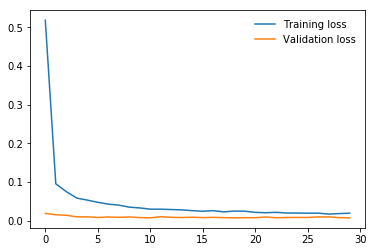

In [77]:
# Visualize train and valid losses, load the best model

# Load the saved model
model.load_state_dict(torch.load('model_v1.pt'))

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

### Test the Trained Network

In [152]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item() * data.size(0)
    
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy())
    
    # Calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss / len(test_loader.dataset)
print('Test loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test accuracy of %5s: %2d%% (%2d/%2d)' % (
             classes[i], 100. * class_correct[i] / class_total[i],
             np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest accuracy (Overall): %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

Test loss: 0.028443

Test accuracy of     0: 99% (971/980)
Test accuracy of     1: 99% (1128/1135)
Test accuracy of     2: 99% (1029/1032)
Test accuracy of     3: 99% (1004/1010)
Test accuracy of     4: 99% (974/982)
Test accuracy of     5: 99% (884/892)
Test accuracy of     6: 98% (948/958)
Test accuracy of     7: 99% (1020/1028)
Test accuracy of     8: 98% (964/974)
Test accuracy of     9: 98% (993/1009)

Test accuracy (Overall): 99% (9915/10000)


### Visualize sample test results

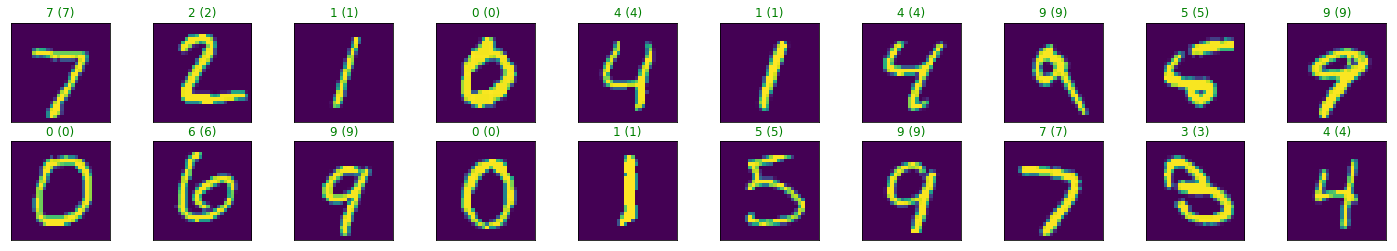

In [153]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))